In [2]:
import numpy as np
import pandas as pd
# import pyvinecopulib as pv
from scipy.stats import beta, norm
import matplotlib.pyplot as plt
from scipy.linalg import cholesky
from numpy.linalg import eigvalsh, LinAlgError
import time

In [3]:
np.random.seed(0)

In [4]:
# Parameters for the beta distribution
alpha, beta_param = 5, 2
sample_size = 100000

In [5]:
beta_sample = beta.rvs(alpha, beta_param, size=(sample_size,15))

In [6]:
# Generate the inputs
def generate_basket_option_inputs(n_samples, n_assets):
    # Generate forward stock prices
    z = np.random.normal(0.5, 0.25, size=(n_samples, n_assets))
    forward_stock_prices = 100 * np.exp(z)

    # Generate stock volatilities
    stock_volatilities = np.random.uniform(0, 1, size=(n_samples, n_assets))

    # Generate maturities
    maturities = np.random.uniform(1, 4, size=n_samples)**2

    # Generate correlation matrices
    correlation_matrices = 2*(beta_sample-0.5)
    
    # Combine all inputs
    inputs = np.column_stack((forward_stock_prices, stock_volatilities, maturities, correlation_matrices))
    
    return inputs

In [7]:
n_samples = 100000
n_assets = 6

In [8]:
basket_option_inputs = generate_basket_option_inputs(n_samples, n_assets)

In [9]:
basket_option_inputs[0]

array([ 1.65716707e+02,  1.48766772e+02,  1.64505928e+02,  1.47403967e+02,
        1.92658218e+02,  1.71360463e+02,  9.83797260e-01,  7.44451246e-01,
        4.58654904e-01,  6.48876060e-01,  2.14262458e-01,  7.73349973e-02,
        1.46517580e+01,  6.22112699e-01,  8.69454154e-01,  3.27102591e-01,
        5.61456927e-01,  4.54386094e-01,  7.19992987e-01, -4.38410743e-01,
        9.31745289e-01,  3.37079578e-01,  8.78294339e-01,  3.53970667e-01,
        7.32991329e-01,  5.16829020e-01,  1.68350899e-01,  1.47840420e-01])

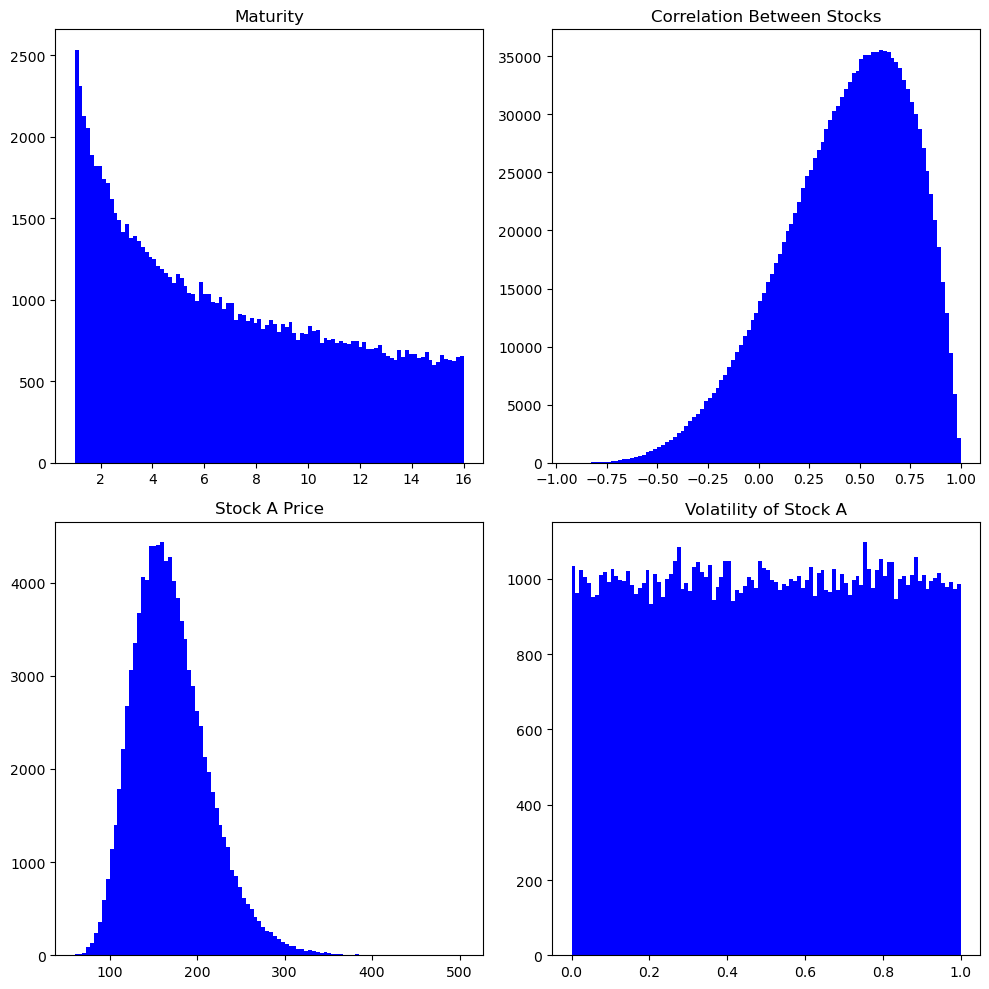

In [10]:
forward_stock_prices = basket_option_inputs[:, :6]
stock_volatilities = basket_option_inputs[:, 6:12]
maturities = basket_option_inputs[:, 12]
# Correlations, reshaped for simplicity
correlations = basket_option_inputs[:, 13:28].reshape(-1)  

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Maturity
axs[0, 0].hist(maturities, bins=100, color='blue')
axs[0, 0].set_title('Maturity')

# Correlation
axs[0, 1].hist(correlations, bins=100, color='blue')
axs[0, 1].set_title('Correlation Between Stocks')

# Stock A Price - example using the first stock price
axs[1, 0].hist(forward_stock_prices[:, 0], bins=100, color='blue')  # Just an example with stock A
axs[1, 0].set_title('Stock A Price')

# Volatility of Stock A - example using the first stock volatility
axs[1, 1].hist(stock_volatilities[:, 0], bins=100, color='blue')  # Just an example with stock A
axs[1, 1].set_title('Volatility of Stock A')

# Show plots
plt.tight_layout()
plt.show()

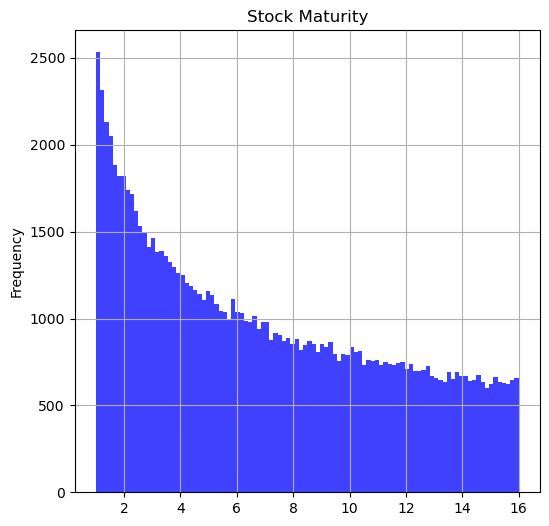

In [19]:
plt.figure(figsize=(6, 6))
plt.hist(maturities, bins=100, alpha=0.75, color='blue')
plt.title('Stock Maturity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [10]:
# Function to price the European call option on a worst-of-basket with Monte Carlo simulation
def price_worst_of_basket_call_option(forward_prices, volatilities, correlations, maturity, strike_price, risk_free_rate, simulations):
    """
    Calculate the price of a European call option on a worst-of-basket with Monte Carlo simulation.

    :param forward_prices: list of forward prices of the stocks
    :param volatilities: list of volatilities of the stocks
    :param correlations: 2D list representing the correlation matrix
    :param maturity: time to maturity of the option in years
    :param strike_price: strike price of the option
    :param risk_free_rate: risk-free interest rate
    :param simulations: number of simulations
    :return: price of the option
    """
    num_stocks = len(forward_prices)

    # Calculate the drift and diffusion coefficients
    drift = (risk_free_rate - 0.5 * np.array(volatilities) ** 2) * maturity
    diffusion = np.array(volatilities) * np.sqrt(maturity)
    
    # Generate random numbers with correlations
    correlated_random_numbers = np.dot(cholesky(correlations, lower=True), norm.rvs(size=(num_stocks, simulations)))
    # Calculate stock prices at maturity
    stock_prices_at_maturity = np.array(forward_prices)[:, np.newaxis] * np.exp(drift[:, np.newaxis] + diffusion[:, np.newaxis] * correlated_random_numbers)
    # Calculate the option payoff for each simulation
    option_payoffs = np.maximum(0, np.min(stock_prices_at_maturity, axis=0) - strike_price)
    # Discount the payoffs to present value
    option_payoffs_pv = np.exp(-risk_free_rate * maturity) * option_payoffs
    # Calculate the option price as the average of the discounted payoffs
    option_price = np.mean(option_payoffs_pv)
    
    return option_price

In [11]:
# Function to construct the correlation matrix from the upper triangle
def construct_correlation_matrix(upper_triangle, epsilon=1e-10):
    # Manually setting n for 6 stocks as we know there should be 15 upper triangle entries (consistent with n=6)
    n = n_assets
    correlation_matrix = np.eye(n)
    upper_indices = np.triu_indices(n, k=1)
    correlation_matrix[upper_indices] = upper_triangle
    correlation_matrix[(upper_indices[1], upper_indices[0])] = upper_triangle  # Symmetrize the matrix

    iteration = 0
    tolerance=1e-10
    max_iterations=100
    while iteration < max_iterations:
        try:
            # Try to perform Cholesky decomposition
            _ = np.linalg.cholesky(correlation_matrix)
            return correlation_matrix  # The matrix is positive definite
        except np.linalg.LinAlgError:
            # If not positive definite, increase diagonal slightly
            min_eigenvalue = min(np.linalg.eigvalsh(correlation_matrix))
            adjustment = np.abs(min_eigenvalue) + tolerance
            np.fill_diagonal(correlation_matrix, np.diag(correlation_matrix) + adjustment)
        iteration += 1
    
    raise ValueError("Could not make the matrix positive definite after max iterations.")
    
    return correlation_matrix

In [14]:
option_prices = []
rf = 0.05
simulations = 100000

start_time = time.time()

for inputs in basket_option_inputs:
    forwards = inputs[:6]
    volatilities = inputs[6:12]
    maturity = inputs[12]
    correlation_upper_triangle = inputs[13:]
    correlations = construct_correlation_matrix(correlation_upper_triangle)
    strike = 100
    
    price = price_worst_of_basket_call_option(forwards, volatilities, correlations, maturity, strike, rf, simulations)
    option_prices.append(price)
    
end_time = time.time()

In [16]:
generation_time = end_time-start_time
generation_time

2969.047294616699

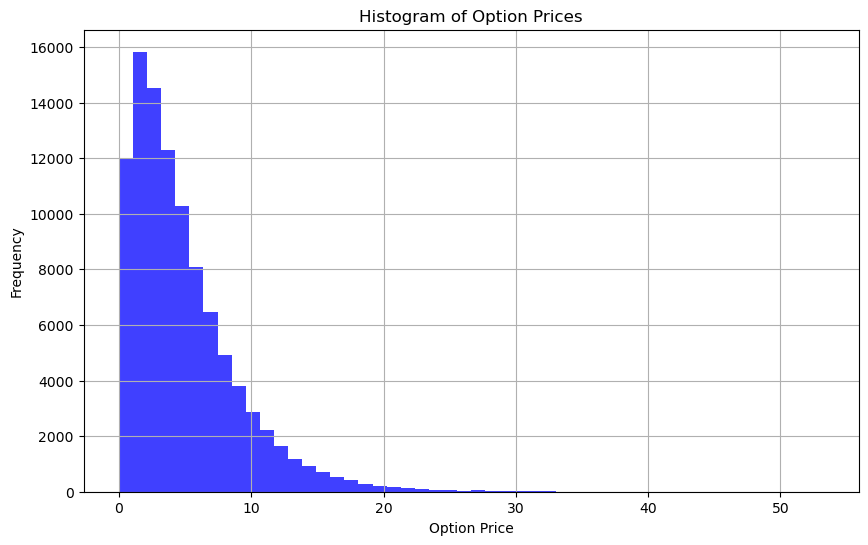

In [17]:
plt.figure(figsize=(10, 6))
plt.hist(option_prices, bins=50, alpha=0.75, color='blue')
plt.title('Histogram of Option Prices')
plt.xlabel('Option Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [18]:
df_x = pd.DataFrame(basket_option_inputs)
df_x.to_csv('data_x.csv', index=False)

In [19]:
df_y = pd.DataFrame(option_prices)
df_y.to_csv('data_y.csv', index=False)